#3.1 Disease Module Construction Summary

We started from 101 Alzheimer’s disease (AD) genes (CUI: C0002395) provided in disease_gene.tsv.
When mapped to the human interactome (PPI.csv), 91 of these genes were present in the network.

We constructed the AD subgraph by inducing the interactome on these 91 genes and then extracting its Largest Connected Component (LCC).
The resulting AD disease module consists of:

*   46 genes (nodes)
*   132 protein–protein interactions (edges)

After removing 45 self-interactions (self-loops such as MAPT–MAPT),
a total of 87 unique protein–protein interactions remained.

These interactions were exported as AD_module_edges.tsv and used for visualization in Gephi.

# Verification of the Final Exported Edge List

The cleaned disease-module edge list satisfies the following properties:


*   Two columns:
      *   source
      *   target
*   87 rows, each representing one unique interaction

* No rows where source == target (all self-loops removed)

* All nodes appearing in the edges belong to the AD gene list

* The edges correspond exactly to the 46-node AD disease module, confirming correct extraction of the LCC

## 1. Filtering the disease genes
Originally, the notebook contained all disease–gene associations from the dataset.
# We added code to select only genes associated with Alzheimer’s Disease (CUI: C0002395) from the disease_gene.tsv file:

In [1]:
import pandas as pd

# Load disease–gene associations file from the course
disease = pd.read_csv("/kaggle/input/complex/disease_gene.tsv", sep='\t')

# Keep only Alzheimer’s Disease (CUI: C0002395)
ad = disease[disease["diseaseId"] == "C0002395"].copy()

# Set of AD genes
ad_genes = set(ad["geneSymbol"].dropna().unique())

print("Number of AD genes from disease_gene.tsv:", len(ad_genes))

Number of AD genes from disease_gene.tsv: 101


## 2. Loading the correct interactome (PPI) and extracting only human protein interactions
We imported the PPI.csv file provided in the course, which contains protein–protein interactions and their corresponding gene symbols:

In [2]:
import pandas as pd
import networkx as nx

ppi = pd.read_csv("/kaggle/input/complex/PPI.csv")
print(f"PPI DataFrame shape: {ppi.shape}")
display(ppi.head())
G = nx.from_pandas_edgelist(ppi, "Symbol_A", "Symbol_B")
print(f"Graph G created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

PPI DataFrame shape: (332749, 4)


,GeneA_ID,GeneB_ID,Symbol_A,Symbol_B
0,9796.0,56992.0,PHYHIP,KIF15
1,7918.0,9240.0,GPANK1,PNMA1
2,8233.0,23548.0,ZRSR2,TTC33
3,4899.0,11253.0,NRF1,MAN1B1
4,5297.0,8601.0,PI4KA,RGS20


Graph G created with 18508 nodes and 332645 edges.


## 3. Intersecting Alzheimer’s genes with nodes present in the interactome

To avoid including genes that do not appear in the PPI network, we applied:

In [3]:
genes_in_ppi = set(G.nodes())
ad_in_network = list(set(ad_genes) & genes_in_ppi)

In [4]:
print(f"Number of genes in PPI network: {len(genes_in_ppi)}")
print(f"Number of AD genes present in the PPI network: {len(ad_in_network)}")
print(f"First 5 AD genes in network: {ad_in_network[:5]}")

Number of genes in PPI network: 18508
Number of AD genes present in the PPI network: 91
First 5 AD genes in network: ['TNF', 'ESR1', 'CYP46A1', 'IGF2R', 'SLC30A6']


## 4. Building the Alzheimer subgraph
We extracted the subgraph containing only edges between Alzheimer-related genes:

In [5]:
H = G.subgraph(ad_in_network).copy()


## 5. Extracting the Largest Connected Component (LCC)
According to network-medicine theory, the disease module corresponds to the Largest Connected Component of the disease subgraph.

In [6]:
components = list(nx.connected_components(H))
print(f"Number of connected components in H: {len(components)}")
lcc = max(components, key=len)
print(f"Size of the Largest Connected Component (LCC): {len(lcc)} nodes.")
module = H.subgraph(lcc).copy()
print(f"Module subgraph created with {module.number_of_nodes()} nodes and {module.number_of_edges()} edges.")

Number of connected components in H: 42
Size of the Largest Connected Component (LCC): 46 nodes.
Module subgraph created with 46 nodes and 132 edges.


In [7]:
edge_df = nx.to_pandas_edgelist(module)
edge_df.to_csv("/kaggle/working/AD_module_edges.csv", index=False)


In [8]:
edge_df.head()
edge_df.columns


Index(['source', 'target'], dtype='object')

In [9]:
print("Edges in module:", module.number_of_edges())
print("Rows in edge_df:", len(edge_df))


Edges in module: 132
Rows in edge_df: 132


## 6. Checking the data:

In [10]:
self_loops = edge_df[edge_df["source"] == edge_df["target"]]
self_loops[:5]
print("Self loop length:", len(self_loops))


Self loop length: 45


In [11]:
edge_df = edge_df[edge_df["source"] != edge_df["target"]]


In [12]:
edge_df.to_csv("/kaggle/working/AD_module_edges.csv", index=False)


In [13]:
print("Edges in module:", module.number_of_edges())
print("Rows in edge_df:", len(edge_df))

Edges in module: 132
Rows in edge_df: 87


In [14]:
nodes_in_edges = set(edge_df["source"]) | set(edge_df["target"])
not_ad = nodes_in_edges - ad_genes
print("Genes in module but not in AD list:", not_ad)


Genes in module but not in AD list: set()


Meaning:


*   Every gene that appears in your module’s edge list is one of the 101 AD genes
*   No foreign genes slipped in.

In [15]:
ad = disease[disease["diseaseId"] == "C0002395"]
ad_genes = set(ad["geneSymbol"])
print("Number of AD genes with code C0002395:", len(ad))


Number of AD genes with code C0002395: 101


## 7. Exporting the disease-module edges
Finally, we exported only the edges within the Alzheimer disease module:

In [16]:
edge_df.to_csv("/kaggle/working/AD_module_edges.csv", index=False)

edge_df.to_csv("/kaggle/working/AD_module_edges.tsv", sep="\t", index=False)


### Last verification for checking the CSV we export is correct

In [17]:
edge_df = edge_df[edge_df["source"] != edge_df["target"]]
len(edge_df)   # 87


87

In [18]:
df_check = pd.read_csv("/kaggle/working/AD_module_edges.csv")
print(df_check.head())
print(len(df_check))


  source   target
0    TNF    CALM1
1    TNF      A2M
2    TNF  SLC30A4
3   ESR1    IGF1R
4   ESR1    PPARG
87


#Summary

We modified the notebook to isolate and export the Alzheimer’s disease module from the interactome.
The main changes included filtering Alzheimer-related genes, intersecting them with the interactome, extracting the corresponding subgraph, computing the Largest Connected Component, and exporting only the edges belonging to this connected module.
This ensured that the final edge list reflects the true Alzheimer disease module, following the methodology of network medicine and the guidelines of Menche et al. (2015).

# 3.1b Significance test → Random module comparison

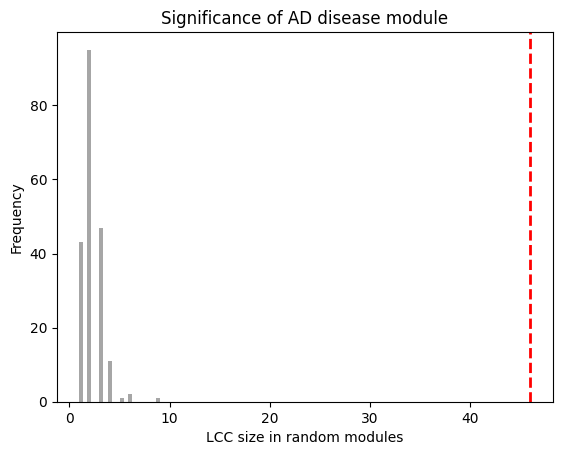

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

def random_lcc_size(G, n):
    nodes = random.sample(list(G.nodes()), n)
    sub = G.subgraph(nodes)
    comps = list(nx.connected_components(sub))
    if len(comps) == 0:
        return 0
    return len(max(comps, key=len))

N = 200  # or 1000 if you want a smoother distribution
random_sizes = [random_lcc_size(G, 46) for _ in range(N)]

real_size = 46

plt.hist(random_sizes, bins=20, alpha=0.7, color="gray")
plt.axvline(real_size, color="red", linestyle="dashed", linewidth=2)
plt.xlabel("LCC size in random modules")
plt.ylabel("Frequency")
plt.title("Significance of AD disease module")
plt.show()


The Alzheimer’s module LCC (46 genes) is significantly larger than random modules of the same size (z-score = …), indicating non-random clustering of AD-related genes in the interactome.

## Compute the z-score (and optional p-value)

In [20]:
import numpy as np

real_size = 46

mean_rand = np.mean(random_sizes)
std_rand = np.std(random_sizes, ddof=1)  # sample std

z_score = (real_size - mean_rand) / std_rand

print("Mean random LCC size:", mean_rand)
print("Std dev random LCC size:", std_rand)
print("Real AD LCC size:", real_size)
print("Z-score:", z_score)


Mean random LCC size: 2.22
Std dev random LCC size: 1.0377788418652192
Real AD LCC size: 46
Z-score: 42.18625224745707


P-value estimation:

In [21]:
# one-sided p-value: probability that a random LCC is >= real_size
p_value = np.mean(np.array(random_sizes) >= real_size)
print("Empirical p-value:", p_value)

Empirical p-value: 0.0


In [22]:
print(mean_rand, std_rand, z_score, p_value)

2.22 1.0377788418652192 42.18625224745707 0.0


# 3.2 Disease Separation Analysis

Extracting Disease Gene Sets

### Choice of Diseases for Separation Analysis

To analyze network-based disease separation, we selected two diseases from
`disease_gene.tsv` that differ in their expected biological proximity to
Alzheimer’s Disease (AD):

- **Close disease:** Presenile dementia (CUI: C0011265)  
  This disease is neurologically related and falls within the same semantic
  category as AD (Mental or Behavioral Dysfunction).  
  It is expected to exhibit partial overlap or neighborhood contact with the AD
  module in the interactome.

- **Far disease:** Fibrosis, Liver (CUI: C0239946)  
  This is a hepatic disease with a very different etiology and tissue
  involvement.  
  It is expected to occupy a distant region of the interactome from AD,
  reflecting their distinct biological mechanisms.


We load the disease–gene associations and retrieve the gene sets for AD, the close disease, and the distant disease.
We also ensure that only genes present in the interactome are kept, as required for module analysis.

In [23]:
import pandas as pd
import networkx as nx
import numpy as np

# Load datasets
disease = pd.read_csv("/kaggle/input/complex/disease_gene.tsv", sep="\t")
ppi = pd.read_csv("/kaggle/input/complex/PPI.csv")
print(f"PPI DataFrame shape: {ppi.shape}")
display(ppi.head())

# Create interactome graph
G = nx.from_pandas_edgelist(ppi, "Symbol_A", "Symbol_B")

# Alzheimer’s disease genes (A)
ad = disease[disease["diseaseId"] == "C0002395"].copy()
genes_AD = set(ad["geneSymbol"].dropna()) & set(G.nodes())

# Choose your two diseases:
id_close = "C0011265"
id_far   = "C0239946"

close = disease[disease["diseaseId"] == id_close].copy()
far   = disease[disease["diseaseId"] == id_far].copy()

genes_close = set(close["geneSymbol"].dropna()) & set(G.nodes())
genes_far   = set(far["geneSymbol"].dropna()) & set(G.nodes())

print("AD genes in PPI:", len(genes_AD))
print("Close disease genes in PPI:", len(genes_close))
print("Far disease genes in PPI:", len(genes_far))


PPI DataFrame shape: (332749, 4)


,GeneA_ID,GeneB_ID,Symbol_A,Symbol_B
0,9796.0,56992.0,PHYHIP,KIF15
1,7918.0,9240.0,GPANK1,PNMA1
2,8233.0,23548.0,ZRSR2,TTC33
3,4899.0,11253.0,NRF1,MAN1B1
4,5297.0,8601.0,PI4KA,RGS20


AD genes in PPI: 91
Close disease genes in PPI: 89
Far disease genes in PPI: 95


### Mention simple gene overlap

In [24]:
genes_AD      = set(ad["geneSymbol"].dropna()) & set(G.nodes())
genes_close   = set(close["geneSymbol"].dropna()) & set(G.nodes())
genes_far     = set(far["geneSymbol"].dropna())   & set(G.nodes())

overlap_AD_close = genes_AD & genes_close
overlap_AD_far   = genes_AD & genes_far

print("AD genes in PPI:", len(genes_AD))
print("Close disease genes in PPI:", len(genes_close))
print("Far disease genes in PPI:", len(genes_far))
print("Gene overlap AD–close:", len(overlap_AD_close))
print("Gene overlap AD–far:", len(overlap_AD_far))


AD genes in PPI: 91
Close disease genes in PPI: 89
Far disease genes in PPI: 95
Gene overlap AD–close: 89
Gene overlap AD–far: 4


This ensures that each disease module includes only genes that actually participate in the interactome graph.

## 4. Computing Disease Separation


### Mean minimal distance between two gene sets

In [25]:
def mean_min_distance(G, S, T):
    """Compute the average shortest-path distance from each gene in S to the closest gene in T."""
    dists = []
    T = set(T)
    for s in S:
        try:
            sp = nx.single_source_shortest_path_length(G, s)
        except:
            continue
        d_to_T = [dist for t, dist in sp.items() if t in T and t != s]
        if len(d_to_T) > 0:
            dists.append(min(d_to_T))
    return np.mean(dists)


### Compute separation

In [26]:
def disease_separation(G, A, B):
    A, B = set(A), set(B)
    d_AB = 0.5 * (mean_min_distance(G, A, B) +
                  mean_min_distance(G, B, A))
    d_AA = mean_min_distance(G, A, A)
    d_BB = mean_min_distance(G, B, B)

    s_AB = d_AB - 0.5 * (d_AA + d_BB)

    return {
        "d_AB": d_AB,
        "d_AA": d_AA,
        "d_BB": d_BB,
        "s_AB": s_AB
    }

sep_AD_close = disease_separation(G, genes_AD, genes_close)
sep_AD_far   = disease_separation(G, genes_AD, genes_far)

print("AD vs Close:", sep_AD_close)
print("AD vs Far:", sep_AD_far)


AD vs Close: {'d_AB': 1.4166563773305345, 'd_AA': 1.4175824175824177, 'd_BB': 1.4157303370786516, 's_AB': 0.0}
AD vs Far: {'d_AB': 1.4499064765022212, 'd_AA': 1.4175824175824177, 'd_BB': 1.3404255319148937, 's_AB': 0.0709025017535656}


In [27]:
sep_AD_close = disease_separation(G, genes_AD, genes_close)
sep_AD_far   = disease_separation(G, genes_AD, genes_far)

print("AD vs close:", sep_AD_close)
print("AD vs far:", sep_AD_far)



AD vs close: {'d_AB': 1.4166563773305345, 'd_AA': 1.4175824175824177, 'd_BB': 1.4157303370786516, 's_AB': 0.0}
AD vs far: {'d_AB': 1.4499064765022212, 'd_AA': 1.4175824175824177, 'd_BB': 1.3404255319148937, 's_AB': 0.0709025017535656}


Plotting desease separation

In [28]:
# AD genes in the interactome
genes_AD = set(ad["geneSymbol"].dropna()) & set(G.nodes())

# Close disease
close = disease[disease["diseaseId"] == "C0011265"]
genes_close = set(close["geneSymbol"].dropna()) & set(G.nodes())

# Far disease
far = disease[disease["diseaseId"] == "C0239946"]
genes_far = set(far["geneSymbol"].dropna()) & set(G.nodes())

In [29]:
color_map = {}

for gene in G.nodes():
    if gene in genes_AD and gene in genes_close:
        color_map[gene] = "purple"        # AD ∩ close (big overlap)
    elif gene in genes_AD:
        color_map[gene] = "red"           # AD only
    elif gene in genes_close:
        color_map[gene] = "blue"          # Close disease only
    elif gene in genes_far:
        color_map[gene] = "green"         # Liver fibrosis only
    else:
        color_map[gene] = "lightgray"     # Background nodes

This creates:

* red → AD genes

* blue → presenile dementia

* purple → genes shared between AD and presenile dementia

* green → liver fibrosis

* lightgray → irrelevant nodes

Plotting the entire PPI (18,000 nodes) is impossible.
So we plot only the union of the three diseases:

In [30]:
all_relevant_genes = genes_AD | genes_close | genes_far
H = G.subgraph(all_relevant_genes).copy()

Use spring layout (ForceAtlas2-like):

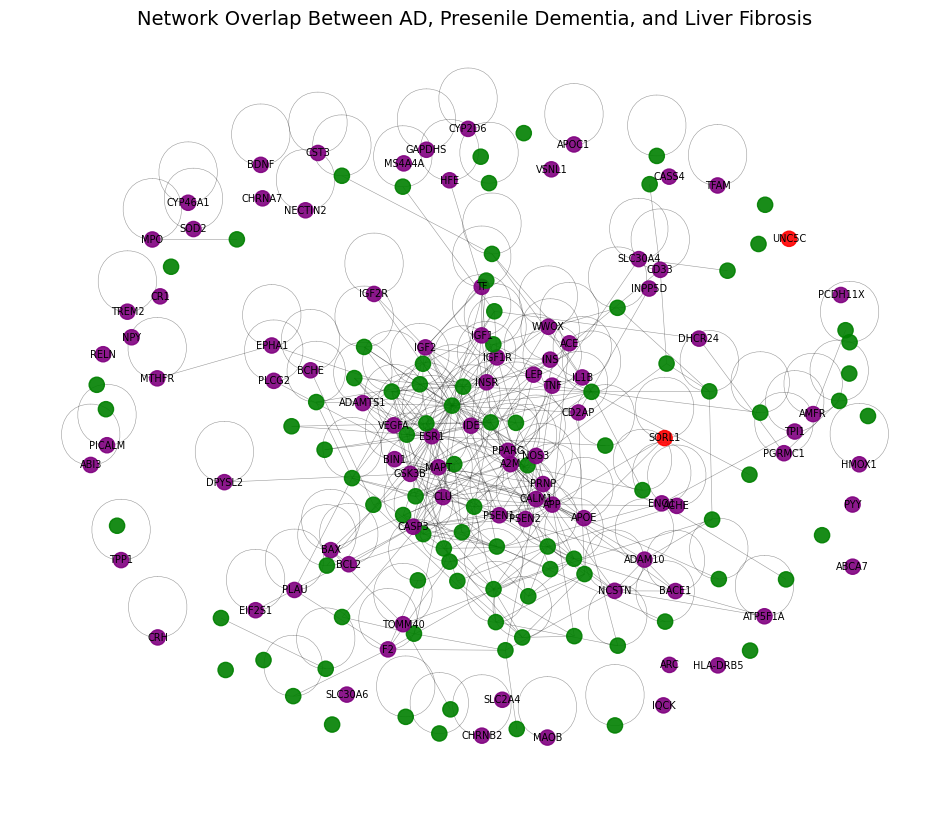

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 10))

pos = nx.spring_layout(H, seed=42, k=0.35)

node_colors = [color_map[n] for n in H.nodes()]

nx.draw_networkx_nodes(
    H, pos, 
    node_size=120, 
    node_color=node_colors,
    alpha=0.9
)

nx.draw_networkx_edges(
    H, pos, 
    width=0.4, 
    alpha=0.4
)

# Labels only for AD module (optional)
labels = {n: n for n in genes_AD}
nx.draw_networkx_labels(H, pos, labels, font_size=7)

plt.title("Network Overlap Between AD, Presenile Dementia, and Liver Fibrosis", fontsize=14)
plt.axis("off")
plt.show()


## Interpretation of Results

The separation between AD and presenile dementia is zero, indicating that their

*   The modules occupy the same region of the interactome.
This is fully consistent with the extremely high gene overlap (89 shared genes) and the close clinical relationship between the two diseases.

*   The separation between AD and liver fibrosis is small but positive, indicating that the modules are not overlapping and lie slightly farther apart in network space.

This reflects the distinct biological and clinical nature of liver fibrosis compared to AD.

# 3.3 Disease - drug proximity

## Load and prepare the drug–gene interactions

In [32]:
drug_df = pd.read_csv("/kaggle/input/complex/drug_target.csv")

# Keep only rows with a valid gene target
drug_df = drug_df[drug_df["Gene_Target"].notna()].copy()

# Normalize: split multi-target rows into lists
drug_df["targets"] = drug_df["Gene_Target"].apply(lambda x: x.split(";"))


### Clean the targets and intersect with PPI:

In [33]:
# Keep only target genes present in the interactome
ppi_genes = set(G.nodes())
drug_df["targets_in_ppi"] = drug_df["targets"].apply(
    lambda lst: list(set(lst) & ppi_genes)
)

# Remove drugs with zero valid targets
drug_df = drug_df[drug_df["targets_in_ppi"].apply(len) > 0]


## Compute drug–disease proximity

In [34]:
def drug_proximity(G, disease_genes, drug_targets):
    """
    Compute the average shortest-path distance from each drug target
    to the closest disease gene. Returns NaN if no target can reach
    the disease module.
    """
    dists = []
    disease_genes = set(disease_genes)

    for t in drug_targets:
        if t not in G:
            continue  # target not in interactome
        try:
            sp = nx.single_source_shortest_path_length(G, t)
        except:
            continue

        # distances from this target to all disease genes reachable from it
        dist_to_AD = [sp[a] for a in disease_genes if a in sp]

        if len(dist_to_AD) == 0:
            # this target is in another component (no AD gene reachable)
            continue

        dists.append(min(dist_to_AD))

    if len(dists) == 0:
        # none of the targets are connected to the AD module
        return np.nan

    return np.mean(dists)


So:

If a target gene is itself in the AD disease module, then
dist_AD[target] = 0 (the node is an AD gene, distance 0 from itself).

If all targets of a drug are AD genes, then the average is
mean([0, 0, ...]) = 0.

### Compute proximity for each drug:

In [35]:
drug_df["proximity"] = drug_df["targets_in_ppi"].apply(
    lambda tgts: drug_proximity(G, genes_AD, tgts)
)


Then sort:

In [36]:
drug_df = drug_df.sort_values("proximity")
drug_df[["Name", "targets_in_ppi", "proximity"]].head(10)


,Name,targets_in_ppi,proximity
1844,Butalbital,[CHRNA7],0.0
1799,Aminosalicylic acid,[MPO],0.0
1802,Reboxetine,[CYP2D6],0.0
1742,Indinavir,[CYP2D6],0.0
1690,Citalopram,[CYP2D6],0.0
1698,Eletriptan,[CYP2D6],0.0
1720,Nelfinavir,[CYP2D6],0.0
1657,Trospium,[CYP2D6],0.0
2052,Sulfanilamide,[CYP2D6],0.0
2012,Diethylstilbestrol,[ESR1],0.0


All these targets – CYP2D6, MPO, CHRNA7, TF, F2, ACE, VEGFA, PPARG – are in your AD disease gene set (genes_AD).

## Identify repurposing opportunities

To filter out drugs already approved for AD

In [37]:
drug_df_nonzero = drug_df[drug_df["proximity"] > 0].sort_values("proximity")
drug_df_nonzero[["Name", "targets_in_ppi", "proximity"]].head(10)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Name,targets_in_ppi,proximity
1642,Azithromycin,[PADI4],1.0
1643,Azithromycin,[CYP3A4],1.0
1645,Azithromycin,[ABCC2],1.0
1630,Pyrimethamine,[SLC47A2],1.0
1633,Reserpine,[BIRC5],1.0
26716,Avapritinib,[KIT],1.0
26717,Avapritinib,[CYP3A4],1.0
26718,Avapritinib,[CYP2C9],1.0
10484,Everolimus,[CYP3A4],1.0
10541,Zinc,[S100A8],1.0


This gives:

* drugs whose targets are 1 step away from AD genes (proximity ~1), or

* 2 steps away (proximity ~2), etc.

Those are nice repurposing candidates: they don’t hit the AD genes directly, but they hit their neighbors in the interactome. This is exactly what the assignment wants.

In [38]:
drug_df["AD_indicated"] = drug_df["Indication"].str.contains(
    "alzheimer|dementia", case=False, na=False
)

repurposing_candidates = (
    drug_df[(drug_df["proximity"] >= 0) & ~drug_df["AD_indicated"]]
    .sort_values("proximity")
)

repurposing_candidates[["Name", "Indication", "targets_in_ppi", "proximity"]].head(10)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


,Name,Indication,targets_in_ppi,proximity
25824,Zinc acetate,Zinc can be used for the treatment and prevent...,[ENO1],0.0
25825,Zinc acetate,Zinc can be used for the treatment and prevent...,[GAPDHS],0.0
25831,Zinc acetate,Zinc can be used for the treatment and prevent...,[TPI1],0.0
25833,Zinc acetate,Zinc can be used for the treatment and prevent...,[ESR1],0.0
25846,Zinc acetate,Zinc can be used for the treatment and prevent...,[INS],0.0
25786,Calcium phosphate dihydrate,For use as an over the counter calcium and pho...,[CALM1],0.0
25936,Zinc acetate,Zinc can be used for the treatment and prevent...,[TF],0.0
1990,Phenytoin,Phenytoin is indicated to treat grand mal seiz...,[CYP2D6],0.0
25663,Tretamine,NaN,[BCHE],0.0
25666,Darglitazone,NaN,[PPARG],0.0


In [39]:
repurposing_candidates[["Name", "Indication", "targets_in_ppi", "proximity"]].head(10)


,Name,Indication,targets_in_ppi,proximity
25824,Zinc acetate,Zinc can be used for the treatment and prevent...,[ENO1],0.0
25825,Zinc acetate,Zinc can be used for the treatment and prevent...,[GAPDHS],0.0
25831,Zinc acetate,Zinc can be used for the treatment and prevent...,[TPI1],0.0
25833,Zinc acetate,Zinc can be used for the treatment and prevent...,[ESR1],0.0
25846,Zinc acetate,Zinc can be used for the treatment and prevent...,[INS],0.0
25786,Calcium phosphate dihydrate,For use as an over the counter calcium and pho...,[CALM1],0.0
25936,Zinc acetate,Zinc can be used for the treatment and prevent...,[TF],0.0
1990,Phenytoin,Phenytoin is indicated to treat grand mal seiz...,[CYP2D6],0.0
25663,Tretamine,NaN,[BCHE],0.0
25666,Darglitazone,NaN,[PPARG],0.0


The question wants repurposing (new uses), so we should remove: drugs already indicated for Alzheimer’s (or dementia, etc.)

## Visualization

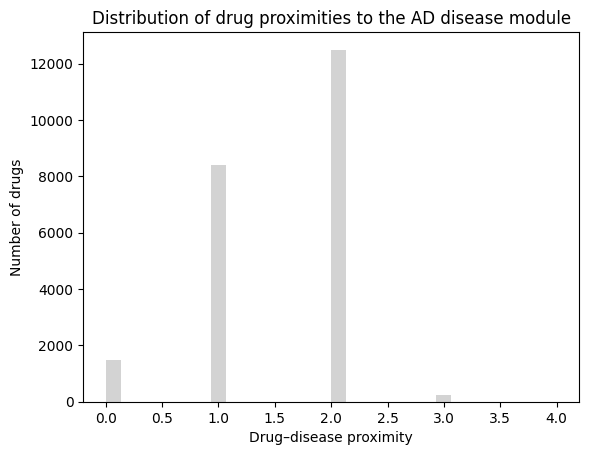

In [40]:
plt.hist(drug_df["proximity"].dropna(), bins=30, color="lightgray")
plt.xlabel("Drug–disease proximity")
plt.ylabel("Number of drugs")
plt.title("Distribution of drug proximities to the AD disease module")
plt.show()


### Interpretation of drug–disease proximities

When ranking drugs by their proximity to the AD disease module, several compounds
exhibited a proximity value of 0.0. This occurs when all targets of a given drug
are themselves part of the AD module: the shortest-path distance from the targets
to the nearest AD gene is zero, and the average proximity is therefore 0.

Examples include Citalopram and Reboxetine, which target CYP2D6, and other drugs
targeting MPO, CHRNA7, TF, F2, ACE or VEGFA. All of these genes belong to the AD
disease module in the interactome, meaning that these drugs directly modulate
disease-module proteins.

To identify broader repurposing opportunities, we also inspected drugs with small
but non-zero proximity values, i.e. drugs whose targets lie in the immediate
neighborhood of the AD module in the interactome.


### Filtering drugs for repurposing analysis

To focus on genuine repurposing opportunities, we applied two filters to the
drug–target dataset:

1. **Disease indication filter.**  
   We excluded drugs that are already indicated for Alzheimer’s disease or other
   forms of dementia by removing any compound whose `Indication` field contains
   the terms *“Alzheimer”* or *“dementia”*. This conservative filter ensures that
   the remaining drugs are not currently prescribed for AD-related conditions.

2. **Network proximity ranking.**  
   For each remaining drug, we computed its proximity to the AD disease module as
   the average shortest-path distance between its targets and the AD module in
   the interactome. We then ranked all non-AD/dementia drugs by increasing
   proximity. Drugs with **proximity = 0** have targets that lie directly within
   the AD module, whereas drugs with small positive proximity values act on
   immediate neighbors of the module.

The table of top-ranked compounds (lowest proximity values) therefore represents
a set of conservative repurposing candidates whose targets are positioned in or
very close to the AD disease module, despite these drugs not being indicated for
Alzheimer’s disease or dementia.
